# Age Detection of Indian Actors

**Problem**

Indian Movie Face database (IMFDB) is a large unconstrained face database consisting of 34512 images of 100 Indian actors collected from more than 100 videos. All the images are manually selected and cropped from the video frames resulting in a high degree of variability in terms of scale, pose, expression, illumination, age, resolution, occlusion, and makeup. IMFDB is the first face database that provides a detailed annotation of every image in terms of age, pose, gender, expression and type of occlusion that may help other face related applications. For more details about the data set, read [here](http://cvit.iiit.ac.in/projects/IMFDB/).

**Data**

The dataset is cleaned and formatted to give you a total of 26742 images with 19906 images in train and 6636 images in test.

The task is to predict the age of a person from his or her facial attributes. For simplicity, the problem has been converted to a multiclass problem with classes as Young, Middle and Old.

The attributes of data are as follows:

- ID – Unique ID of image

- Class – Age bin of person in image

# Solution Approach

We will be using fastai to build a model for performing this image classification. 

We will create a CNN Learner, tune the learning rate and use prebuilt model resnet50 for classifying the images. (I tried both resnet18 and resnet34 but those models didn't have enough capacity to differentiate between these classes, hence upscaled to resnet50).


## Getting fastai in Google Colab

In order to be able to use fastai in Google Colab environment, run the following command and by navigating to the **Runtime** option in toolbar, click on the **Change Runtime Type** option and select GPU from the new Form that pops up and make sure to uncheck "Omit Codecell output while saving this notebook" option. More support [here.](https://course.fast.ai/start_colab.html)

In [1]:
# To install fastai in this Colab Instance
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
# To get the details of Graphics Card Instance to which our instance is connected
!nvidia-smi

Fri Feb 28 09:49:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import os                                                                       # For navigating directories and repositories
from google.colab import drive                                                  # For getting data from the drive
drive.mount('/content/drive', force_remount = True)                             # Mounting the drive

from tqdm import tqdm_notebook as tqdm                                          # To time the prediction loop and look at it's progress

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Get all the necessary functions and modules for image classification from fastai
from fastai import * 
from fastai.vision import *

# Data Preparation and Loading Data

One of the crucial steps when building an Artificial Neural Network for doing an ML task is to load the data in a systematic way and pass it to the model for traiing.

fastai makes it very easy to load data progressively in batches and provides a good API to load data having different formats. 

eg. You can load data from 
- **csv_file**: This is how we are going to load our data. The images are provided in a folder and the labels/classes for the same are provided in a csv file. 

- **from_df**: If we have a pandas dataframe that holds the image names, then we can create an `ImageList` object which can then be used to create a DataBunch.

- **from_folder**: If the structure of data is in the format similar to imagenet i.e. train and test folders are separate and train contains subfolder of each class which holds instances of images from that class, then this is the goto function for loading data.
___

Currently, we will create an ImageList object from csv file provided and also add a test set to it. Then we will create an ImageDataBunch from this list to feed the model.

## Image Augmentation
It is a technique in which the images are modified in some small way to create new images so that our model can learn from a new set of data in addition to the current set. This is a common technique which is used to expand our trainset in case we have limited training data or so. 

The transformation functions in fastai facilitate easy use of transforms in order to augment a set of images, some of which are as follows (these are the ones I used for this classification task).

- **[brightness](https://docs.fast.ai/vision.transform.html#_brightness)**: Given a range of brightness values and a probability(p) of applying these to the image, it returns a brightened image (with probability p) which has it's intensity between min and max specified intensities. 

- **[contrast](https://docs.fast.ai/vision.transform.html#_contrast)**: Similar to brightness, provide a range of contrast and a probability of application of this transform.

- **[rotate](https://docs.fast.ai/vision.transform.html#_rotate)**: Given a range of degrees of rotation as a tuple and a probability, it applies a uniformly randomly selected angle from that range, rotates the image(with probability p) and returns the same.

- **[jitter](https://docs.fast.ai/vision.transform.html#_jitter)**: This is a method of unsharpening the image i.e. it takes the image and within small regions of the image, it substitutes pixels from it's local neighborhoods. This gives a blurred version of the image. The amount of blurriness is controlled by the magnitude parameter which can be specified as a range along with the probability of application of this transform p.

This is all for the data preparation step. After this, we wil create a learner object to train our model.

In [5]:
# Navigate to the folder which contains all our images
base_path = '/content/drive/My Drive/Age_Detection_Hackathon'
os.chdir(base_path)
print(os.getcwd())

/content/drive/My Drive/Age_Detection_Hackathon


In [6]:
# To check the contents of train csv file
import pandas as pd
imgs = pd.read_csv('train.csv')
imgs.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [0]:
# Image Augmentation transforms
transforms = [brightness(change = (0.1, 0.6), p = .3),
              contrast(scale = (.1, 1.5), p = .3),
              rotate(degrees=(-5, 5), p = .3),
              rand_zoom(scale = (1,1.2), p = .3),
              jitter(magnitude = (-.02, .02), p = .1)]

In [18]:
# Define the list of images split as per train and test in an ImageList instance
source = ImageList.from_df(imgs, path = base_path + '/Train')\
                          .split_by_rand_pct(valid_pct = 0.1)\
                          .label_from_df(cols = ['Class']) 

source.add_test_folder(test_folder = base_path + '/Test')

LabelLists;

Train: LabelList (17916 items)
x: ImageList
Image (3, 102, 82),Image (3, 133, 82),Image (3, 200, 133),Image (3, 89, 91),Image (3, 104, 64)
y: CategoryList
YOUNG,MIDDLE,MIDDLE,MIDDLE,YOUNG
Path: /content/drive/My Drive/Age_Detection_Hackathon/Train;

Valid: LabelList (1990 items)
x: ImageList
Image (3, 67, 58),Image (3, 65, 45),Image (3, 54, 37),Image (3, 41, 25),Image (3, 105, 74)
y: CategoryList
YOUNG,YOUNG,YOUNG,OLD,YOUNG
Path: /content/drive/My Drive/Age_Detection_Hackathon/Train;

Test: LabelList (6645 items)
x: ImageList
Image (3, 40, 34),Image (3, 74, 67),Image (3, 191, 114),Image (3, 45, 33),Image (3, 128, 102)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/Age_Detection_Hackathon/Train

In [0]:
# Create a databunch with the above images
dt = source.transform(tfms = [transforms, None], size = 128)\
            .databunch(bs = 32)\
            .normalize(imagenet_stats)

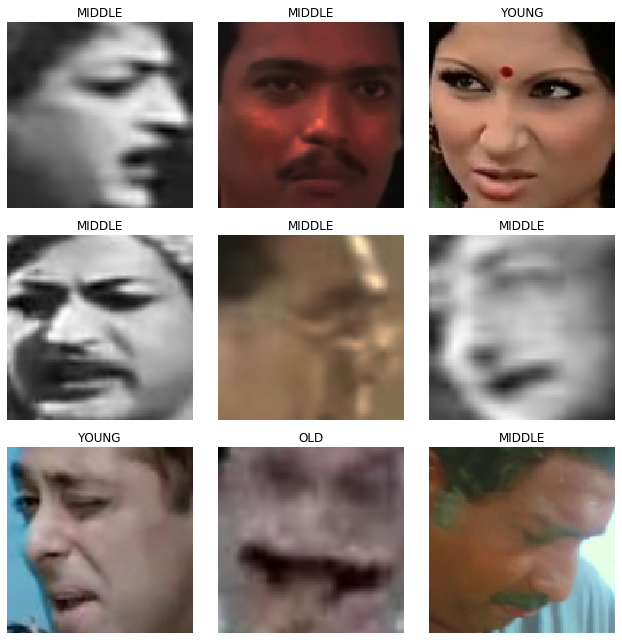

In [0]:
# Look at a batch of images
dt.show_batch(rows = 3, figsize = (9,9))

# Model Building and Training

Transfer Learning is the savior. It is the method where we take a pretrained architecture and modify it to suit our classification task.

In ANNs layers, the learning happens in a hierarchical fashion. So, if we already have some architectures like ResNet and VGG which are trained on a dataset like ImageNet which has a million images and a thousand classes, then it has seen enough data to observe a lot of things in nature and learned to extract edges, corners, curves etc. of which we can make use of.

Hence we'll define a learner object based upon a pretrained architecture and use it to train our model further. With fastai's `cnn_learner` module, this task becomes quite easy. We just have to specify the databunch on which we wanna train, the pretrained model and the metrics we wish to monitor during training.

For this example, let's use a resnet34 model and monitor the accuracy as we go training the architecture.

In [0]:
learn.dl = dt.dl

In [0]:
# Define the learner object
learn = cnn_learner(dt, models.resnet50, metrics=[error_rate, accuracy])
# learn = load_learner(path = '/content/drive/My Drive/Age_Detection_Hackathon/Train/models', file = 'model-1.pth')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
# Find a suitable learning rate by finding and plotting the curve
learn.lr_find()

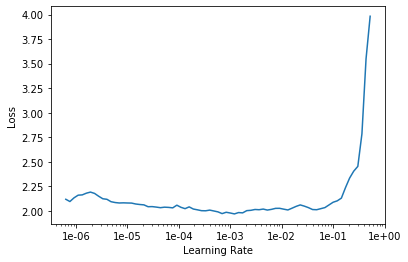

In [0]:
learn.recorder.plot()

In [0]:
# Fit for one cycle
learn.fit_one_cycle(1, slice(1e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.907924,0.739741,0.324121,0.675879,44:01


In [0]:
# Save the model
learn.export('model-1.pkl')

epoch,train_loss,valid_loss,error_rate,accuracy,time


Traceback (most recent call last):


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


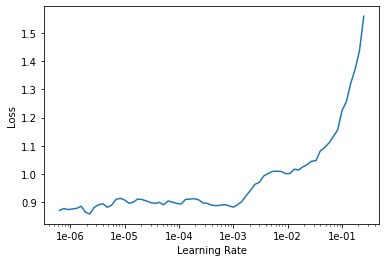

In [0]:
# Unfreeze the model and look at the learning rate finder
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
# Train the model for a few more epochs
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.788607,0.663204,0.267337,0.732663,01:53
1,0.615279,0.602104,0.239698,0.760302,01:50
2,0.471636,0.415779,0.160804,0.839196,01:50
3,0.294803,0.347430,0.131658,0.868342,01:50
4,0.189192,0.343948,0.125126,0.874874,01:49


In [0]:
# Look at the learning rate and select a suitable one
learn.lr_find()
learn.recorder.plot()

In [0]:
# Train for a few more epochs
learn.fit_one_cycle(5, 1e-5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.188730,0.348116,0.122613,0.877387,01:51
1,0.176965,0.359326,0.124121,0.875879,01:56
2,0.142862,0.359289,0.123618,0.876382,01:55
3,0.124805,0.358594,0.117085,0.882915,01:56
4,0.118326,0.358404,0.118090,0.881910,01:58


In [0]:
learn.save('model-2-resnet50-state.pkl')
learn.export('model-2-resnet50.pkl')

# Model Evaluation and Prediction

The validation dataset can be used in order to evaluate the performance of our model since it was never used before in training. 

fastai allows us to easily achieve this with the `ClassificationInterpretation` class and you could create an instance of this class using the learn object and optionally a test dataset.

With this class you can interpret the results in the following ways.
- `interp.top_losses()` - This function returns the losses and indices of the same in a descending order of losses i.e. The image for which the loss was highest is the first and the one for which it's lowest is the last.

- `inter.plot_top_losses(n)` - It plots the top n images whose loss is the highest. This can help understand where our classifier makes mistakes more often and what kind of classes does it find difficult to classify.

- `interp.most_confused()` - This method tells which two classes get mixed up more often and give the model a hard time in prediction.

In the above points, interp is an instance of ClassificationInterpretation class which is loaded with the learner that we've created previously.

    Top Losses  Indices
0        7.518      318
1        7.311     1470
2        7.231      455
3        6.649      302
4        6.059      220
5        5.765     1390
6        5.748     1634
7        5.612     1830
8        5.551     1286
9        5.450     1968
10       5.336      744
11       5.160      760





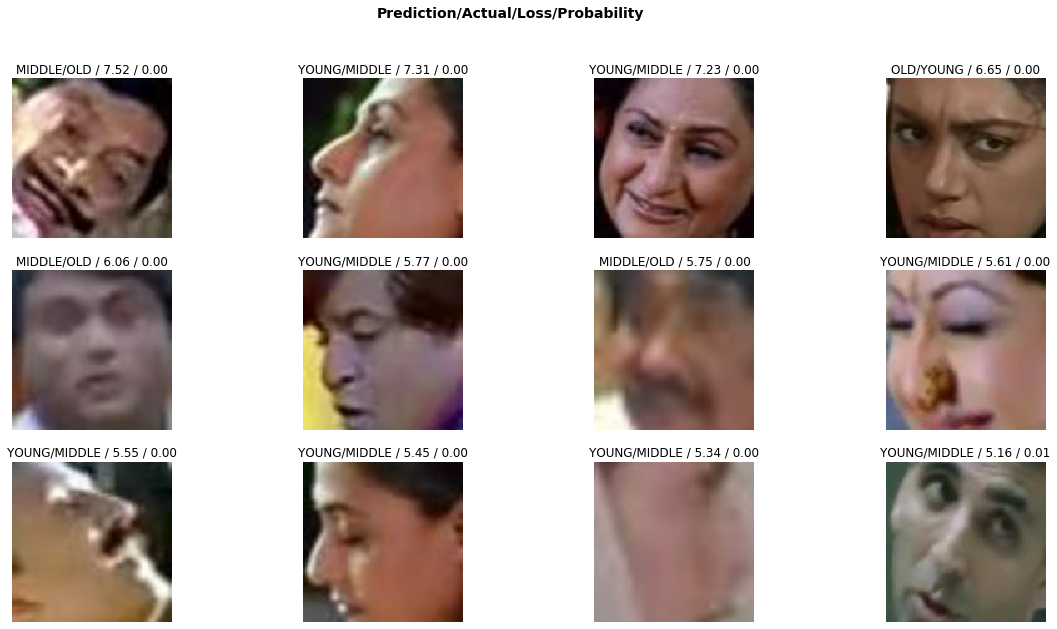

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

# Have a look at the classes which were most misclassified
# i.e. The model strongly believed the instance passed belonged to an 
# alternate class and not the actual intended class.
print(pd.DataFrame({"Top Losses":np.round(losses, 3), "Indices":idxs})[:12])
print('\n\n')
interp.plot_top_losses(12, figsize=(20,10))

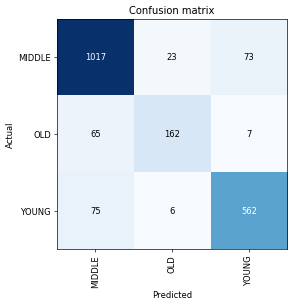

In [0]:
# Draw a confusion matrix to figure out the classifier performance
# All values should be concentrated along the diagonal and not at other places.
# For a good fit
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [0]:
# Look out for values which were most confused, i.e.
# Those values on cm other than diagonal which are highly populated
interp.most_confused(min_val=1)

[('YOUNG', 'MIDDLE', 75),
 ('MIDDLE', 'YOUNG', 73),
 ('OLD', 'MIDDLE', 65),
 ('MIDDLE', 'OLD', 23),
 ('OLD', 'YOUNG', 7),
 ('YOUNG', 'OLD', 6)]

In [0]:
# Make predictions on the test data
categories = []
labels = []
prob_dists = []

for predictor, label in tqdm(dt.test_ds):
  # Make a prediction
  category, prediction, prob_dist = learn.predict(predictor)
  
  # Record the true label, prediction and probability distribution for the
  # Prediction
  categories.append(category)
  labels.append(label)
  prob_dists.append([round(i.item(), 4) for i in list(prob_dist)])

In [0]:
def get_name(item):
  return str(item).split('/')[6]

In [0]:
# Get the names of images in a container
image_names = [get_name(i) for i in dt.test_ds.items]

In [0]:
# Get the categories that we obtained above in a container 
# After casting them to string type from the original category type
categories = [str(c) for c in categories]

In [0]:
# Create a dataframe of image names and categories
submissions = pd.DataFrame({'Class':categories, 'ID':image_names})

In [0]:
# Read in the sample submission file and get all the image-names for which predictions are needed
# Only keep those image predictions in our dataframe and then convert it to csv and save it to the disk
samples = pd.read_csv('sample_submission.csv')
submissions = submissions.loc[[i in list(samples['ID']) for i in submissions['ID']],]
submissions.to_csv('test_submission.csv', sep = ',', index = False)

Alternatively you could also use a saved learner later to get the predictions for a model. You can do this as given below. The block is commented since we've already found out the predictions in the code block above.

**Note**:

In order to load a learner that you've saved earlier and make predictions, you must have **exported** the learner earlier, **not saved it** in order to load it and do the predictions.

In order to further train an existing learner, you will have to have first **saved** the learner, **not exported it** in order to load it and train further.

In [0]:
# ts = ImageList.from_folder('/content/drive/My Drive/Age_Detection_Hackathon/Test')
# learn = load_learner(path = '/content/drive/My Drive/Age_Detection_Hackathon/Train/',file = 'model-2-resnet50.pkl', test = ts)

# preds, _ = learn.get_preds(ds_type=DatasetType.Test)

# categories = {0:'MIDDLE', 1:'OLD', 2:'YOUNG'}
# names = [str(item).split('/')[6] for item in learn.data.test_ds.items]
# predictions = [categories[i] for i in preds.argmax(dim = 1).numpy()]
# submissions = pd.DataFrame({'Class':predictions, 'ID':names})

# samples = pd.read_csv('sample_submission.csv')
# submissions = submissions.loc[[i in list(samples['ID']) for i in submissions['ID']],]
# submissions.to_csv('test_submission_loaded.csv', sep = ',', index = False)